
# Tutorial: Traj Segmentation 

**The following notebook illustrate the `TrajSegmentation` class.**



* Loading dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from megabouts.tracking_data import TrackingConfig,load_example_data,FullTrackingData
from megabouts.config import TrajPreprocessingConfig,TrajSegmentationConfig
from megabouts.preprocessing import TrajPreprocessing
from megabouts.segmentation import Segmentation

## Loading Data and Preprocessing

* TrackingConfig and TrackingData similar to [tutorial_Tail_Preprocessing](./tutorial_Tail_Preprocessing.ipynb)

In [2]:
df_recording, fps, mm_per_unit = load_example_data('fulltracking_posture')

tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')

head_x = df_recording['head_x'].values*mm_per_unit
head_y = df_recording['head_y'].values*mm_per_unit
head_yaw = df_recording['head_angle'].values
tail_angle = df_recording.filter(like='tail_angle').values

tracking_data = FullTrackingData.from_posture(head_x = head_x,
                                              head_y = head_y,
                                              head_yaw = head_yaw,
                                              tail_angle = tail_angle)
t = np.arange(tracking_data.T)/tracking_cfg.fps

traj_preprocessing_cfg = TrajPreprocessingConfig(fps=tracking_cfg.fps)
traj_df_input = tracking_data.traj_df
traj = TrajPreprocessing(traj_preprocessing_cfg).preprocess_traj_df(traj_df_input)

# Segmentation using kinematic vigor

* Set the threshold to 0.5:

In [9]:
traj_segmentation_cfg = TrajSegmentationConfig(fps=tracking_cfg.fps,
                                               peak_prominence=1)

* Apply segmentation to `traj.vigor`:

In [10]:
segmentation_function = Segmentation.from_config(traj_segmentation_cfg)
segments = segmentation_function.segment(traj.vigor)

* We can visualize the results of the segmentation:

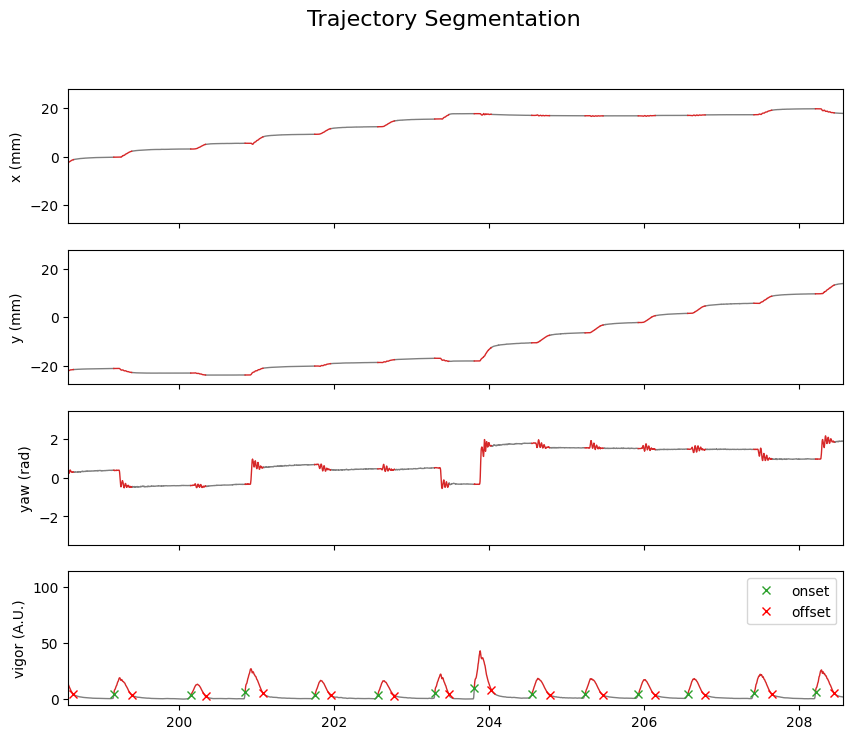

In [17]:
is_bouts = np.zeros(tracking_data.T, dtype=bool)
# Set to True for the indices within the bouts
for on_, off_ in zip(segments.onset, segments.offset):
    is_bouts[on_:off_] = True

IdSt = 139000
Duration = 10*tracking_cfg.fps

fig,ax = plt.subplots(4,1,figsize=(10,10),sharex=True)
fig.suptitle('Trajectory Segmentation', fontsize=16)

traj_list = [tracking_data._head_x,tracking_data._head_y,tracking_data._head_yaw,traj.vigor]
traj_name = ['x (mm)','y (mm)','yaw (rad)','vigor (A.U.)']
for i,(x,label_) in enumerate(zip(traj_list,traj_name)):
    
    x_bouts = np.where(is_bouts, x, np.nan)
    x_nobouts = np.where(is_bouts==False, x, np.nan)

    ax[i].plot(t,x_nobouts,'tab:gray',lw=1)
    ax[i].plot(t,x_bouts,'tab:red',lw=1)
    ax[i].set(ylabel=label_)
    if i==3:
        ax[i].plot(t[segments.onset], x[segments.onset], "x",color='tab:green',label='onset')
        ax[i].plot(t[segments.offset], x[segments.offset], "x",color='red',label='offset')
        ax[i].legend()



t = np.arange(tracking_data.T)/tracking_cfg.fps

ax[1].set_xlim(t[IdSt],t[IdSt+Duration])

plt.show()

* To find the ideal segmentation threshold for your dataset, it is useful to compute the number of bouts detected as a function of the threshold:

In [6]:
# Number of bouts as function of threshold:
thresh_list = np.linspace(0.1,20,100)
num_bouts = np.zeros_like(thresh_list)

for i,thresh in enumerate(thresh_list):
    traj_segmentation_cfg = TrajSegmentationConfig(fps=tracking_cfg.fps,
                                                   peak_prominence=thresh)
    segmentation_function = Segmentation.from_config(traj_segmentation_cfg)
    segments = segmentation_function.segment(traj.vigor)
    num_bouts[i] = len(segments.onset)



* For very small threshold values, too many bouts are detected, while for large threshold values, no bouts are detected. There is an optimal range between these extremes where a suitable threshold can be found:

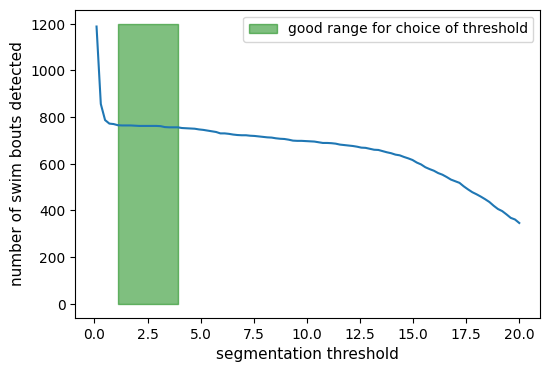

In [7]:
fig,ax = plt.subplots(figsize=(6,4))
ax.plot(thresh_list,num_bouts)

ax.fill_between(thresh_list, 0, 1200, where=(num_bouts < 767)&(num_bouts > 755),
                color='green', alpha=0.5,label='good range for choice of threshold')
ax.legend()
ax.set_ylabel('number of swim bouts detected',fontsize=11)
ax.set_xlabel('segmentation threshold',fontsize=11)
plt.show()